In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import traceback
import random
import pickle
import torch
import yaml
import copy
import time 
import os

from ddpg.reader import LoadGeckoPandasExperiment
from ddpg.replay_buffer import ReplayBuffer
from ddpg.trainer import Trainer
from ddpg.checkpoint import *
from ddpg.losses import GeckoLoss
from ddpg.ddpg import DDPG

from holodecml.vae.optimizers import *
from holodecml.vae.tqdm import tqdm

from torch.optim.lr_scheduler import *
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt

### Load the configuration file

In [2]:
with open("config.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

### Load the data splits

In [6]:
experiment_data = LoadGeckoPandasExperiment(**config["data"])

In [7]:
fn = "../clustered/experiment_data/experiment_train_test_val_splits.pkl"
with open(fn, "rb") as fid:
    train, valid, test = pickle.load(fid)

In [8]:
train_data_set = LoadGeckoPandasExperiment(
    **config["data"],
    experiment_subset = train,
    x_data = experiment_data.x,
    y_data = experiment_data.y
)

In [9]:
config["data"]["shuffle"] = False

In [10]:
valid_data_set = LoadGeckoPandasExperiment(
    **config["data"],
    experiment_subset = valid,
    x_data = experiment_data.x,
    y_data = experiment_data.y
)

In [11]:
test_data_set = LoadGeckoPandasExperiment(
    **config["data"],
    experiment_subset = test,
    x_data = experiment_data.x,
    y_data = experiment_data.y
)

### Get GPU device

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


### Load the models

In [5]:
policy = DDPG(**config["policy"], device = device)

In [33]:
policy.pretrain_load("results/pretrain/best.pt")

# critic_dict = torch.load("results/100/critic_best.pt", map_location=lambda storage, loc: storage)
# policy.critic.load_state_dict(critic_dict["model_state_dict"])
# policy.critic_target = copy.deepcopy(policy.critic)

# actor_dict = torch.load("results/100/actor_best.pt", map_location=lambda storage, loc: storage)
# policy.actor.load_state_dict(actor_dict["model_state_dict"])
# policy.actor_target = copy.deepcopy(policy.actor)

### Load the replay buffer

In [34]:
replay_buffer = ReplayBuffer(**config["replay_buffer"], device = device)

In [35]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
def Reward(true, pred, timestep, tolerance = 0.05):
    #mse = torch.mean(torch.abs((action - y)**2), 1) ** (1/2)
    #return 1.0 - mse
    
    ### Positive signal
    dirac_delta_prec = (torch.abs(true[:, 0]-pred[:, 0]) < tolerance).to(torch.float32)
    dirac_delta_gas = (torch.abs(true[:, 1:15]-pred[:, 1:15]) < tolerance).to(torch.float32)
    dirac_delta_aero = (torch.abs(true[:, 15:]-pred[:, 15:]) < tolerance).to(torch.float32)
    dirac_delta = (dirac_delta_prec + dirac_delta_gas + dirac_delta_aero) / 3.0
    encouragement = torch.mean(dirac_delta, 1)
    
    ### Negative signal
    #discouragement = torch.mean(torch.abs((action - y)**2), 1) ** (1/2)
    
    return (1440.0 - timestep) * encouragement / 1440.0

class Trainer:

    def __init__(self, 
                 policy, 
                 train_generator, 
                 validation_generator, 
                 test_generator, 
                 replay_buffer,
                 device,
                 start_epoch = 0,
                 epochs = 100,
                 batches_per_epoch = 1e10,
                 experiment_batch_size = 1,
                 batch_size = 64,
                 max_timestep = 1439,
                 teacher_force = False, 
                 gamma = 1.0,
                 clip = 1.0,
                 max_state = 1.0,
                 expl_noise = 0.1):
        
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        self.experiment_batch_size = experiment_batch_size
        
        self.train_gen = train_generator
        self.valid_gen = validation_generator
        self.test_gen = test_generator
        
        self.replay_buffer = replay_buffer
        self.max_timestep = max_timestep
        
        self.policy = policy
        self.teacher_force = teacher_force
        self.gamma = gamma
        
        self.device = device
        self.clip = clip
        self.max_state = max_state
        self.expl_noise = expl_noise 
                
        #############################################
        #
        # Gradient clipping through hook registration
        #
        #############################################
        for p in self.policy.actor.parameters():
            p.register_hook(lambda grad: torch.clamp(grad, -clip, clip))
        for p in self.policy.critic.parameters():
            p.register_hook(lambda grad: torch.clamp(grad, -clip, clip))
        logger.info(f"Clipping gradients to range [-{clip}, {clip}]")
        
        #############################################
        #
        # Fix the number of batches per epoch
        #
        #############################################
        batches_per_epoch = int(self.train_gen.__len__()) 
        if self.batches_per_epoch > batches_per_epoch:
            self.batches_per_epoch = batches_per_epoch
        
        #############################################
        #
        # Load the training experiments and randomly shuffle
        #
        #############################################
        self.train_experiments = list(range(len(self.train_gen.experiment_subset)))
        self.train_experiments_copy = list(range(len(self.train_gen.experiment_subset)))
        random.shuffle(self.train_experiments)
        if self.experiment_batch_size > 1:
            self.train_experiments = list(chunks(
                self.train_experiments, 
                self.experiment_batch_size
            ))
        self.reshuffle = 0 # when == len(self.train_experiments), reshuffle
    
    def train_one_epoch(self, epoch):
        
        self.policy.actor.train()
        self.policy.critic.train()
        
        if self.reshuffle == len(self.train_experiments):
            random.shuffle(self.train_experiments)
            if self.experiment_batch_size > 1:
                self.train_experiments = list(chunks(
                    self.train_experiments_copy, 
                    self.experiment_batch_size
                ))
            self.reshuffle = 0
        
        batch_group_generator = tqdm(
            enumerate(self.train_experiments[self.reshuffle:]),
            total=min(self.batches_per_epoch,len(self.train_experiments[self.reshuffle:])),
            leave=True
        )
        
        cost = self.tf_annealer(epoch)
        
        episode_mae = []
        episode_value = []
        episode_reward = []
        for batch_idx, exp in batch_group_generator:
            experiment_value = 0.0
            experiment_reward = 0.0
            for i, (x,y,w) in enumerate(self.train_gen.__getitem__(exp)):
                x = x.to(self.device)
                y = y.to(self.device)
                w = w.to(self.device)
                
                # Teacher-forcer selection
                idx = [bn for bn in range(x.size(0)) if cost < random.random()]
                if not self.teacher_force: # Never force
                    state = x.clone() if i == 0 else next_state
                    action = self.policy.actor(state)
                elif len(idx) and (i > 0): # Conditional force
                    state = x.clone()
                    action = y.clone()
                    action[idx] = self.policy.actor(state)[idx]
                else: # Always force
                    state = x.clone()
                    action = y.clone()
                
                # Add exploration to the policy
                #if self.expl_noise > 0.0:
                    #noise = torch.empty(self.policy.action_dim).normal_(
                    #    mean=0.0, std=self.max_state * self.expl_noise
                    #)
                    #action += noise.to(self.device)
                    #action = action.clamp(0.0, self.max_state)
                
                next_state = state.clone()
                next_state[:, :self.policy.action_dim] = action # next state = predicted action
                
                reward = Reward(action, y, i+1)
                value = self.policy.critic(state, action)
                stop_early = int((i+1) == self.max_timestep)
                game_over = int((i+1) == 1439)
                        
                for j in range(state.size(0)):
                    self.replay_buffer.add(
                        state[j].cpu().detach().numpy(), 
                        action[j].cpu().detach().numpy(), 
                        next_state[j].cpu().detach().numpy(), 
                        reward[j].cpu().detach().numpy(), 
                        game_over
                    )
                
                experiment_value += torch.mean(value).item()
                experiment_reward += torch.mean(reward).item()
        
                # Train agent after collecting sufficient data
                if (self.replay_buffer.size >= self.replay_buffer.min_size):
                    self.policy.train(self.replay_buffer, self.batch_size)

                if game_over or stop_early:
                    break
                    
            episode_value.append(experiment_value)
            episode_reward.append(experiment_reward)
                                
            # update tqdm
            ep_value = np.mean(episode_value)
            ep_reward = np.mean(episode_reward)
            to_print = f"Episode {epoch + 1} training reward: {ep_reward:.3f} value: {ep_value:.3f}"
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()
            
            self.reshuffle += 1
            if batch_idx > 0 and (batch_idx % self.batches_per_epoch) == 0:
                break
            
        return np.mean(episode_reward)
    
        
    def test(self, epoch):
        self.policy.actor.eval()
        self.policy.critic.eval()
        with torch.no_grad():
            batch_group_generator = tqdm(
                enumerate(range(len(self.valid_gen.experiment_subset))),
                total=len(self.valid_gen.experiment_subset), 
                leave=True
            )
            episode_value = []
            episode_reward = []
            for batch_idx, exp in batch_group_generator:
                experiment_value = 0.0
                experiment_reward = 0.0
                for i, (x,y,w) in enumerate(self.valid_gen.__getitem__(exp)):
                    x = x.to(self.device)
                    y = y.to(self.device)
                    state = x if i == 0 else next_state.clone()
                    action = self.policy.actor(state).clamp(0.0, self.max_state).detach()
                    next_state = state.detach()
                    next_state[:, :self.policy.action_dim] = action # next state
                    
                    #loss = torch.mean(torch.abs((action - y)**2), 1) ** (1/2)
                    #reward = 1.0 - loss
                    reward = Reward(action, y, i+1)
                    value = self.policy.critic(state, action).detach()
                    
                    experiment_value += torch.mean(value).item()
                    experiment_reward += torch.mean(reward).item()
                    
                episode_value.append(experiment_value)
                episode_reward.append(experiment_reward)

                # update tqdm
                ep_value = np.mean(episode_value)
                ep_reward = np.mean(episode_reward)
                to_print = f"Episode {epoch + 1} validation reward: {ep_reward:.3f} value: {ep_value:.3f}"
                batch_group_generator.set_description(to_print)
                batch_group_generator.update()

        return np.mean(episode_reward)
    
    def train(self,
              scheduler,
              early_stopping,
              metrics_logger):
            
        logger.info(
            f"Training the model for up to {self.epochs} epochs starting at epoch {self.start_epoch}"
        )

        flag_actor = isinstance(scheduler[0], torch.optim.lr_scheduler.ReduceLROnPlateau)
        flag_critic = isinstance(scheduler[1], torch.optim.lr_scheduler.ReduceLROnPlateau)

        for episode in range(self.start_epoch, self.epochs):
            train_loss = self.train_one_epoch(episode)
            test_loss = train_loss #self.test(episode)

            if scheduler[0] is not None:
                scheduler[0].step(-test_loss if flag_actor else episode)
            if scheduler[1] is not None:
                scheduler[1].step(-test_loss if flag_critic else episode)
            
            early_stopping(
                episode, 
                -test_loss, # we want to maximize the reward rather than min a loss
                self.policy.actor, 
                self.policy.actor_optimizer,
                self.policy.critic, 
                self.policy.critic_optimizer
            )

            # Write results to the callback logger 
            result = {
                "episode": episode,
                "train_loss": train_loss,
                "valid_loss": test_loss,
                "lr_actor": early_stopping.print_learning_rate(self.policy.actor_optimizer),
                "lr_critic": early_stopping.print_learning_rate(self.policy.critic_optimizer),
                "forcing_score": self.tf_annealer(episode) if self.teacher_force else 1.0
            }
            metrics_logger.update(result)

            if early_stopping.early_stop:
                logger.info("Early stopping")
                break
                
    def tf_annealer(self, epoch):
        return 1.0 * self.gamma ** epoch

### Load the trainer class

In [36]:
trainer = Trainer(
    policy, 
    train_data_set, 
    valid_data_set, 
    test_data_set, 
    replay_buffer,
    device = device,
    **config["trainer"]
)

### Load the callbacks

In [37]:
path_save = config["callbacks"]["path_save"]

# Initialize LR annealing scheduler 
if "ReduceLROnPlateau" in config["callbacks"]:
    schedule_config = config["callbacks"]["ReduceLROnPlateau"]
    scheduler_actor = ReduceLROnPlateau(policy.actor_optimizer, **schedule_config)
    scheduler_critic = ReduceLROnPlateau(policy.critic_optimizer, **schedule_config)
    #logging.info(
    #    f"Loaded ReduceLROnPlateau learning rate annealer with patience {schedule_config['patience']}"
    #)
elif "ExponentialLR" in config["callbacks"]:
    schedule_config = config["callbacks"]["ExponentialLR"]
    scheduler_actor = ExponentialLR(policy.actor_optimizer, **schedule_config)
    scheduler_critic = ExponentialLR(policy.critic_optimizer, **schedule_config)
    #logging.info(
    #    f"Loaded ExponentialLR learning rate annealer with reduce factor {schedule_config['gamma']}"
    #)
schedulers = [scheduler_actor, scheduler_critic]

# Early stopping
checkpoint_config = config["callbacks"]["EarlyStopping"]
checkpoint_config["path_save"] = os.path.join(path_save, "checkpoint.pt")
early_stopping = EarlyStopping(**checkpoint_config)

# Write metrics to csv each epoch
metrics_config = config["callbacks"]["MetricsLogger"]
metrics_config["path_save"] = path_save
metrics_logger = MetricsLogger(**metrics_config)

### Train the models

In [38]:
trainer.train(schedulers, early_stopping, metrics_logger)

Episode 1 training reward: 17.262 value: -26859.370: 100%|██████████| 160/160 [02:11<00:00,  1.22it/s]
Episode 11 training reward: 27.623 value: 31.106: 100%|██████████| 160/160 [06:45<00:00,  2.53s/it]
Episode 12 training reward: 26.775 value: 27.722:   9%|▉         | 14/160 [00:37<06:27,  2.65s/it]


KeyboardInterrupt: 

### Evaluate the best policy found

In [18]:
actor_dict = torch.load("results/100_no_tf/actor_best.pt", map_location=lambda storage, loc: storage)
trainer.policy.actor.load_state_dict(actor_dict["model_state_dict"])

<All keys matched successfully>

In [19]:
critic_dict = torch.load("results/100_no_tf/critic_best.pt", map_location=lambda storage, loc: storage)
trainer.policy.critic.load_state_dict(critic_dict["model_state_dict"])

<All keys matched successfully>

In [39]:
trainer.policy.actor.eval()
trainer.policy.critic.eval()

Critic(
  (l1): Linear(in_features=35, out_features=10000, bias=True)
  (l2): Linear(in_features=10029, out_features=1000, bias=True)
  (l3): Linear(in_features=1000, out_features=1, bias=True)
)

In [40]:
exp = 0

In [41]:
y_true, y_pred = [], []
experiment_value = []
experiment_reward = []
for i, (x,y,w) in enumerate(test_data_set.__getitem__(exp)):
    x = x.to(device)
    y = y.to(device)
    state = x if i == 0 else next_state.clone()
    action = trainer.policy.actor(state).detach()
    next_state = state.detach()
    next_state[:, :trainer.policy.action_dim] = action # next state
    
    loss = nn.L1Loss()(action, y)
    reward = 1.0 - loss
    value = trainer.policy.critic(state, action).detach()

    experiment_value.append(value.item())
    experiment_reward.append(reward.item())
    y_true.append(y)
    y_pred.append(action)

In [42]:
def quantities(Y):
    a, b, c = [], [], []
    for y in Y:
        y = y[0, :]
        prec = y[0]
        gas = y[1:15].sum(-1)/14
        aero = y[15:].sum(-1)/14
        a.append(prec.item())
        b.append(gas.item())
        c.append(aero.item())
    return a, b, c

In [43]:
prec_pred, gas_pred, aero_pred = quantities(y_pred)
prec_true, gas_true, aero_true = quantities(y_true)

(0.0, 1.01)

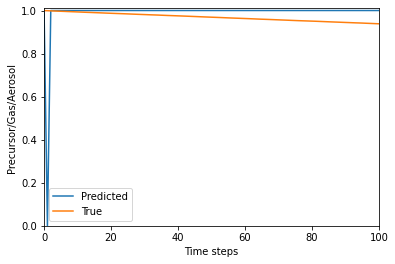

In [44]:
plt.plot(range(len(prec_pred)), prec_pred)
plt.plot(range(len(prec_pred)), prec_true)

plt.legend(["Predicted", "True"])

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.xlim([0, 100])
plt.ylim([0.0, 1.01])

(0.0, 1.01)

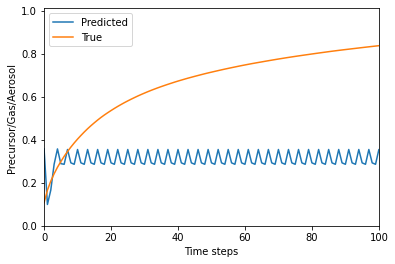

In [45]:
plt.plot(range(len(prec_pred)), gas_pred)
plt.plot(range(len(prec_pred)), gas_true)

plt.legend(["Predicted", "True"])

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.xlim([0, 100])
plt.ylim([0.0, 1.01])

(0.0, 1.01)

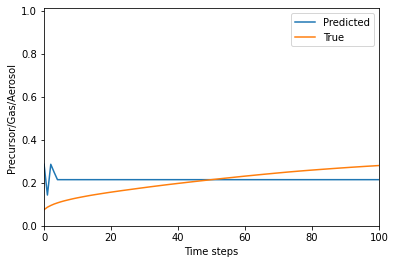

In [46]:
plt.plot(range(len(prec_pred)), aero_pred)
plt.plot(range(len(prec_pred)), aero_true)

plt.legend(["Predicted", "True"])

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.xlim([0, 100])
plt.ylim([0.0, 1.01])

(0.0, 0.8354372620582581)

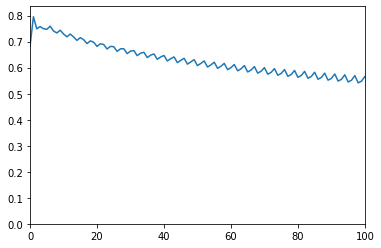

In [47]:
plt.plot(range(len(experiment_reward)), experiment_reward)

plt.xlim([0, 100])
plt.ylim([0, 1.05 * max(experiment_reward)])